# Understanding the DIGIT classification on MNIST dataset

### MNIST data set consists of digits from 0- 9
-  Each sample image is 28x28 and linearized as a vector of size 1x784. 

# **Downloading the dependencies- LIME**

In [2]:
#installing lime and other dependencies
!pip install lime 

# **Importing necessary packages**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images

# **Fetching the dataset and adjusting the images (reshape for lime to function)**

In [0]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
# make each image color so lime_image works correctly
X_vec = np.stack([gray2rgb(iimg) for iimg in mnist.data.reshape((-1, 28, 28))],0)
y_vec = mnist.target.astype(np.uint8)

# **Sample Image in dataset**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Digit: 4')

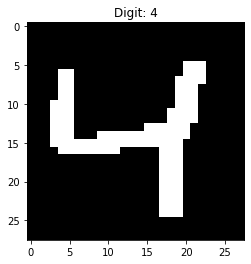

In [5]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.imshow(X_vec[2], interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_vec[2]))

##**Let's Setup a pipeline**

**For what?**
- For processing the images where we flatten the image back to 1d vectors and then use a RandomForest Classifier.


In [0]:
#importing necessary libraries
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

In [0]:
class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)

In [0]:
#converting image to gray
makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])

#Flatenning the image to 1D array
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

In [0]:
#Setting up the main pipeline
simple_dt_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    #('Normalize', Normalizer()),
    #('PCA', PCA(16)),
    ('DT', DecisionTreeClassifier(criterion = "gini", 
            random_state = 100,max_depth=7, min_samples_leaf=5) )
                              ])

**Preparing the test train split for the model**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.55)

**Training the model**

In [11]:
#training a random forest
simple_dt_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('Make Gray', <__main__.PipeStep object at 0x7f28ceccdb70>),
                ('Flatten Image', <__main__.PipeStep object at 0x7f28ceccdc50>),
                ('DT',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=7, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=5, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=100,
                                        splitter='best'))],
         verbose=False)

# Let's see how the decision tree performs

In [12]:
y_pred = simple_dt_pipeline.predict(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix


print("Accuracy: ", accuracy_score(y_test, y_pred)*100 , "%")
print("Confusion Matrix: \n",confusion_matrix(y_test, y_pred))
print("\n\n",classification_report(y_test, y_pred))

Accuracy:  77.80952380952381 %
Confusion Matrix: 
 [[2597    3   19   59   62  204   61    3   62   42]
 [   1 3146  126   53    6   36   17   51   34   52]
 [  60   67 2450   51  121   59   85   60   75   89]
 [  41   17  169 2258   52  416   21   44   68  124]
 [  19   15   53   27 2414  112   58   52   46  325]
 [  60   56   23  180  102 2075   83   32   82  137]
 [  61   46  118   19  232  115 2353    8   67   83]
 [  15   32  174   33   39   44   27 2636   21  262]
 [  16   75  101  123  102  230   97   31 2102  186]
 [  31    9   39  114  143  130   27  129   39 2479]]


               precision    recall  f1-score   support

           0       0.90      0.83      0.86      3112
           1       0.91      0.89      0.90      3522
           2       0.75      0.79      0.77      3117
           3       0.77      0.70      0.74      3210
           4       0.74      0.77      0.76      3121
           5       0.61      0.73      0.66      2830
           6       0.83      0.76   

In [0]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime

## Explaining the inference using LIME.
Does it explain better than our existing metrics?


In [0]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
#LimeImageExplainer object explains the inference
'''
  lime.lime_image.LimeImageExplainer(kernel_width=0.25, verbose=False, feature_selection='auto')
  verbose – if true, print local prediction values from linear model
'''
explainer = lime_image.LimeImageExplainer(verbose = False)

In [0]:
'''
first argument: algo_type: string, segmentation algorithm among the following: 'quickshift', 'slic', 'felzenszwalb'
quickshift: segmentation using 
slic: segmentation using k-means
felzenszwalb: minimum spanning tree based clustering on the image grid
quickshift mode-seeking algorithm

kernel_size = Width of Gaussian kernel used in smoothing
max_dist: Cut-off point for data distances. Higher means fewer clusters.
ratio: range [0,1] Balances color-space proximity and image-space proximity
'''
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [0]:
%%time

#testidx can be changed to check for different examples
testidx = 7
'''
  An Explanation object (see explanation.py) with the corresponding explanations.
'''

explanation = explainer.explain_instance(X_test[testidx], 
                                         classifier_fn = simple_dt_pipeline.predict_proba, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

In [0]:
#marking the positive features
'''
  num_features: number of superpixels to include in explanation
  min_weight: minimum weight of the superpixels to include in explanation

  Returns:
            (image, mask), where image is a 3d numpy array and mask is a 2d
            numpy array that can be used with
            skimage.segmentation.mark_boundaries
'''

temp, mask = explanation.get_image_and_mask(y_test[testidx], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[testidx]))



In [0]:
#marking the negative features
temp, mask = explanation.get_image_and_mask(y_test[testidx], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[testidx]))

##**Visualisation false positives for class of the select testidx**


In [0]:
# now let's see this for every class
idx = 10
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,X_test[idx], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[idx]))
    c_ax.axis('off')

##Can we find an explanation for a classification that the algorithm classified incorrectly??

# **EXERCISE**
Here you can run the below cell, where a random wrong predciton is analysed.
- You can change parameters like num_samples, top_labels and see the effect of adding parameter batch_size=10 and change the value of batch size.
- You can also change the segmenter by changing Segmentation algorithm here. Choose from these ['quickshift', 'slic', 'felzenszwalb']


```
SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)
```





In [0]:
pipe_pred_test = simple_dt_pipeline.predict(X_test)

#selecting a random 
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])

print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test[wrong_idx], pipe_pred_test[wrong_idx]))

Using #22061 where the label was 3 and the pipeline predicted 9


In [0]:
#time elapsed for prediction

%%time
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)
explanation = explainer.explain_instance(X_test[wrong_idx], 
                                         classifier_fn = simple_dt_pipeline.predict_proba, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

CPU times: user 2.04 s, sys: 796 ms, total: 2.84 s
Wall time: 2.17 s


##Comparing predicted vs Actual class

In [0]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[wrong_idx]))
    c_ax.axis('off')

# Summary and Resources

Here, we have used Random forest to classify the digits
- To learn more about how random forest works: https://bit.ly/2r1WxbQ
- A description of MNIST dataset: https://en.wikipedia.org/wiki/MNIST_database
- Understanding how LIME works on regression try this: https://pythondata.com/local-interpretable-model-agnostic-explanations-lime-python/